# DAT19 Lab 13
## Ensemble Methods: Aggregating Models


Today's lab covers:
1. Investigating the Decision Boundaries
2. Growing a Random Forest

The theory used to introduce these concepts can be a bit high level. We postulate a theoretical *true* classification **f** function that perfectly labels a data point given a large enough set of input features. We try to come as close as possible to this **f** with our learned classifier **h**. 

The concept of our *hypothesis space* is what we explore when we take our data, learn a model, and determine the "score" of our model. In theory, a cross validated score of 100 is as close as we can get to **f** and all these improvements we make to our classifiers are moving through the hypothesis space, approaching **f**.

This theoretical component has no true lab but in a sense is every lab that we've covered. Whenever we compare the performance of two separate models, we are comparing the difference from two distinct starting points in the hypothesis space.

A way to demonstrate this will be the basis of the first part of our lab.

In [21]:
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis  as QDA

from bokeh.plotting import figure,gridplot,show,output_notebook
from bokeh.models import Range1d
output_notebook()

%matplotlib inline

ImportError: No module named discriminant_analysis

##Investigating Decision Boundaries
Visually understanding how some classifiers make decisions; adapted from an sklearn page, which will be shared after lab. 

The goal here is to investigate the code and describe in layman's terms what is happening in the specific chunk. If there is a variable being referenced outside of your chunk, or your in a loop, refer to what's happening in one iteration of the loop.

In [19]:

# ====================================================================== #
# Part 1

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "LDA", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LDA(),
    QDA()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]



NameError: name 'LDA' is not defined

Describe here what is going on:

In [17]:
full_grid = []
for data in datasets:
    
# NOTE THIS IS A FOR LOOP, so decribe what happens on one iteration
# ====================================================================== #
# Part 2

    h = .02  # step size in the meshgrid
    
    X, y = data
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

# ====================================================================== #
    # Part 3
    raw = figure(title="Raw Data", tools='',
                x_range=(xx.min(), xx.max()), 
                y_range=(yy.min(), yy.max()),
                width=180, plot_height=220,
                min_border=1,
                title_text_font_size='10pt' )

    color_dict = {0:'blue',1:'red'}

    train_colors = [color_dict[label] for label in y_train]
    raw.circle(X_train[:, 0], X_train[:, 1], 
               color=train_colors)

    test_colors = [color_dict[label] for label in y_test]
    raw.circle(X_test[:, 0], X_test[:, 1], 
               color=test_colors, alpha=0.6)


    
# ====================================================================== #
# Part 4

    row=[raw]
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        
        Z = Z.reshape(xx.shape)
        Z = Z/Z.max()
        control_row = np.ones(Z.shape[1])+0.001
        #NOTE: control row adds a max value outside of the grid to correct colors. 
        # Don't worry about explaining control_row
        Z = np.vstack((Z,control_row))


# ====================================================================== #
# Part 5
        p1 = figure(title=name, tools='',
                    x_range=(xx.min(), xx.max()), 
                    y_range=(yy.min(), yy.max()),
                    width=180, plot_height=220,
                    min_border=1,
                    title_text_font_size='10pt')


        p1.image(image=[Z], x=[xx.min()], y=[yy.min()], dw=[xx.max()-xx.min()], dh=[yy.max()-yy.min()],
                palette='RdYlBu11')

        p1.circle(X_train[:, 0], X_train[:, 1], 
                  color=train_colors,
                  line_color='black',
                  size=3)
        p1.circle(X_test[:, 0], X_test[:, 1], 
                  color=test_colors, 
                  alpha=0.6,
                  line_color='black',
                  size=3)

        p1.text(x=[xx.max()-1.5],y=[yy.min()],
                text=[str(score)],
                text_font_size='15pt',
                text_font_style='bold')
        
        row.append(p1)
    
    grid = np.array(row).reshape(2,len(row)/2)
    full_grid.append(grid)
    
final_grid = np.vstack(full_grid)
show(gridplot(final_grid.tolist()))

NameError: name 'datasets' is not defined

### Random Forests
Random forests are a type of ensemble method (which we hinted at above) that build out groups of decision trees

In [5]:
from sklearn.cross_validation import ShuffleSplit

titanic = pd.read_csv('../data/titanic.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


Let's preprocess our data. Age needs to be imputed or dropped, Sex needs to be converted to a boolean data type, and to use our categorical feature `Embarked` we must use `pd.get_dummies` on it

In [6]:
average_age = titanic['Age'].mean()
titanic['Age'] = titanic['Age'].fillna(average_age)

In [7]:
titanic['is_female'] = titanic.Sex=='female'
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_female
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,False


In [8]:
embarked_categories = pd.get_dummies(titanic.Embarked,prefix='Embarked')
titanic[embarked_categories.columns] = embarked_categories
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_female,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,False,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,True,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,True,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,True,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,False,0,0,1


In [9]:
feature_columns = 'Age,Parch,Pclass,Fare,Embarked_C,Embarked_Q,Embarked_S'.split(',')
for train,test in ShuffleSplit(len(titanic),test_size=.2,n_iter = 1):

    X_train = titanic[feature_columns].iloc[train]
    y_train = titanic['Survived'].iloc[train]
    X_test = titanic[feature_columns].iloc[test]
    y_test = titanic['Survived'].iloc[test]
    
  

In [10]:
# We already imported the RandomForest above, but here it is for reference:
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rfc = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3)
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.68715083798882681

This is an interesting general score but let's be more thorough and get a cross evaluation score, and see how it grows with the size of our forest (`n_estimators`).

In [11]:
from sklearn.cross_validation import cross_val_score

features = titanic[feature_columns]
target = titanic['Survived']

forest_size = range(2,100,2)
y = []
for i in forest_size:
    rfc = RandomForestClassifier(max_depth=5, n_estimators=i, max_features=4)
    accuracy = cross_val_score(rfc, features, target, cv=5).mean()
    
    y.append(accuracy)
p1 = figure(title='Random Forest Classifier performance',tools='')
p1.line(x=forest_size,y=y, color='green')


show(p1)

NameError: name 'figure' is not defined

How does the classifier change as we allow for more complexity?  (i.e. deeper trees)

In [ ]:
tree_depth = range(1,50)
y = []
for i in tree_depth:
    rfc = RandomForestClassifier(max_depth=i, n_estimators=20, max_features=4)
    accuracy = cross_val_score(rfc, features, target, cv=5).mean()
    
    y.append(accuracy)
p1 = figure(title='Random Forest Classifier performance',x_axis_label='Max Tree Depth',tools='')
p1.line(x=tree_depth,y=y, color='green')


show(p1)

## Exercise: Random Forest Regression

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('../data/cell_phone_churn.csv')
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
state             3333 non-null object
account_length    3333 non-null int64
area_code         3333 non-null int64
intl_plan         3333 non-null object
vmail_plan        3333 non-null object
vmail_message     3333 non-null int64
day_mins          3333 non-null float64
day_calls         3333 non-null int64
day_charge        3333 non-null float64
eve_mins          3333 non-null float64
eve_calls         3333 non-null int64
eve_charge        3333 non-null float64
night_mins        3333 non-null float64
night_calls       3333 non-null int64
night_charge      3333 non-null float64
intl_mins         3333 non-null float64
intl_calls        3333 non-null int64
intl_charge       3333 non-null float64
custserv_calls    3333 non-null int64
churn             3333 non-null bool
dtypes: bool(1), float64(8), int64(8), object(3)
memory usage: 524.0+ KB


In [27]:
# Some Preprocessing
state_encoder = LabelEncoder()  
df.state = state_encoder.fit_transform(df.state)


binary_columns = ['intl_plan', 'vmail_plan']  
for col in binary_columns:  
    df[col] = df[col].map({
            'no': 0,
            'yes': 1
    })


Steps:
----
Explore the data and plot histograms of several columns. Hypothesize whether a relationship exists. 


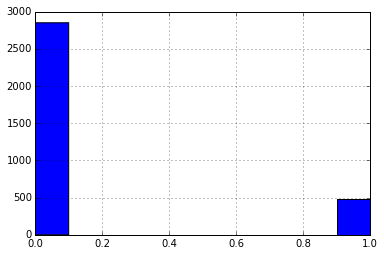

In [30]:
# To get you started:
df['churn'].hist()

SyntaxError: invalid syntax (<ipython-input-34-c4af04b72925>, line 1)

Evaluate and compare the `precision and recall` of 
    - `GradientBoostingClassifier` 
    - `RandomForestClassifier`
    - `DecisionTreeClassifier`
    - `LogisticRegression`
        - hint!: use the `precision_recall_fscore_support` built into sklearn 

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
help(precision_recall_fscore_support)

Help on function precision_recall_fscore_support in module sklearn.metrics.classification:

precision_recall_fscore_support(y_true, y_pred, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)
    Compute precision, recall, F-measure and support for each class
    
    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.
    
    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.
    
    The F-beta score can be interpreted as a weighted harmonic mean of
    the precision and recall, where an F-beta score reaches its best
    value at 1 and worst score

Tune the models using a grid-search of several parameters 
    - Determine which score (accuracy? F1 score? ...) you will use for your grid search. Explain why to your partner
    - Hint: for `DecisionTreeClassifier` and `RandomForestClassifier`, 
        look at the docs to see which hyperparameters need tuning.  



In [31]:
help data churn


SyntaxError: invalid syntax (<ipython-input-31-6fe032064120>, line 1)

Plot feature importance for one of your models (using the `.feature_importances_` property)
    - Hint: load `feature_importances_` into a `pandas.Series` and use `.plot(kind='barh')` 


5 Plot a learning curve for the same model
    - Hint: This one is tough! Remember that a learning curve is the cross_validation score of a model on the training and test sets as the model learns more and more data.

In [ ]:
#Your Code here






